In [75]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
import copy
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
import h5py

Cutting the MH budget method refers to Korattikara's 2014 paper

Adaptive MH method refers to Bardenet's 2014 paper

In [76]:
# generate some ground truth
N = 10000;
sigma1_sq = 10
sigma2_sq = 1
sigmax_sq = 2
theta1 = 0
theta2 = 1

# Generate the data matrix. Note that the np.random.normal(...) requires STD (not VAR).
X = np.zeros(N)
for i in xrange(N):
    u = np.random.random()
    if (u < 0.5):
        X[i] = np.random.normal(theta1, np.sqrt(sigmax_sq))
    else:
        X[i] = np.random.normal(theta1+theta2, np.sqrt(sigmax_sq))


def log_f(theta, X, N, T):
    scale_and_temp = N / float(len(X) * T)
    
    inverse_covariance = np.array([[0.1,0],[0,1]])
    prior_constant = 1.0 / (2*np.pi*np.sqrt(10))
    prior = np.log(prior_constant) - 0.5*(theta.T).dot(inverse_covariance).dot(theta)
    
    X_all = X.reshape((len(X),1))
    ll_constant = (1.0 / (4*np.sqrt(np.pi)))
    L = ll_constant * (np.exp(-0.25*(X_all-theta[0])**2) + np.exp(-0.25*(X_all-(theta[0]+theta[1]))**2))
    log_likelihood = np.sum(np.log(L)) * scale_and_temp
    
    assert (N / float(len(X))) >= 1
    assert not np.isnan(prior + log_likelihood)
    return (prior + log_likelihood)[0,0]

K = 200
T = 100.0 # Temperature
xlist = np.linspace(-1.5,2.5, num=K)
ylist = np.linspace(-3, 3, num=K)
X_a,Y_a = np.meshgrid(xlist, ylist)
Z_a = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        theta = np.array( [[X_a[i,j]],[Y_a[i,j]]] )
        Z_a[i,j] = log_f(theta, X, N, T) 

In [77]:
# plot test result with Gaussian Mixture Model
# test parameters : with nsamps = 5000, minibatchsize = 100, sigma_proposer = 0.5
# number of data points = 10,000, temperature = 100
'''load data '''
f = h5py.File('gaussiandata.mat','r');
samples1 = np.array(f['newtestsamples'])
samples2 = np.array(f['oldtestsamples'])
samples3 = np.array(f['cutmhsamples'])
samples4 = np.array(f['adaptivemhsamples'])
samples5 = np.array(f['cutmhwithsamples'])
size1 = np.array(f['newtestsize'])
size2 = np.array(f['oldtestsize'])
size3 = np.array(f['cutmhsize'])
size4 = np.array(f['adaptivemhsize'])
size5 = np.array(f['cutmhwithsize'])
ll1 = np.array(f['newtestll'])
ll2 = np.array(f['oldtestll'])
ll3 = np.array(f['cutmhll'])
ll4 = np.array(f['adaptivemhll'])
bc1c2 = np.array(f['adaptivemhbc1c2'])
time_list = np.array(f['time_list'])

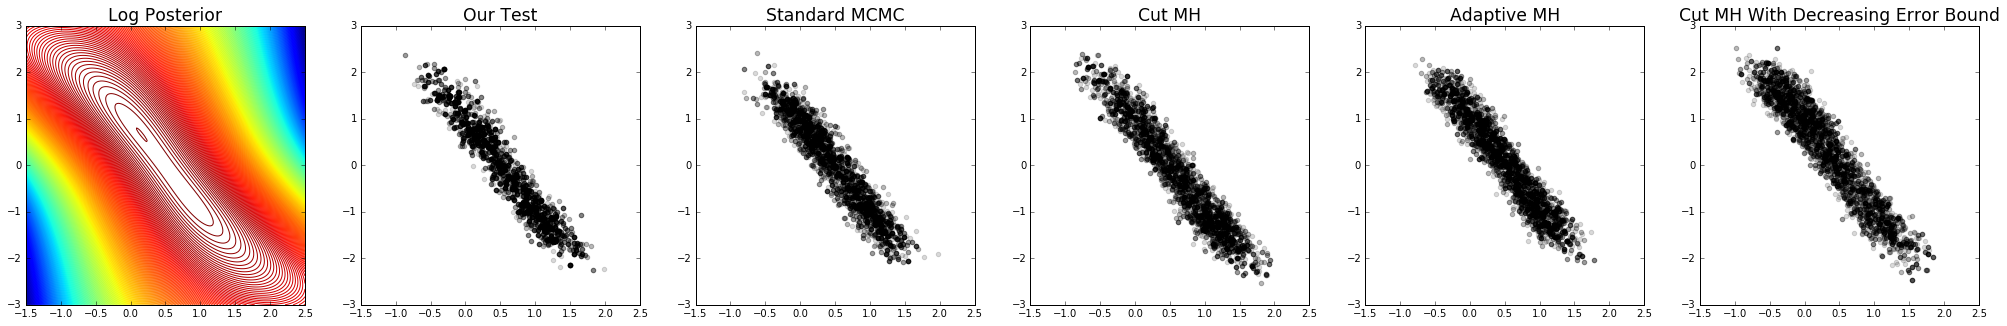

In [92]:
mymap2 = plt.get_cmap("Greys")
m_c2 = mymap2(400)

fig, axarr = plt.subplots(1,6, figsize=(35, 5))
axarr[0].set_title("Log Posterior", size="xx-large")
axarr[0].contour(X_a,Y_a,Z_a,300)

# plot posterior distribution
axarr[1].set_title("Our Test", size="xx-large")
axarr[1].scatter(samples1[:,0], samples1[:,1], color = m_c2, alpha=0.15)
axarr[1].set_xlim([-1.5,2.5])
axarr[1].set_ylim([-3,3])

axarr[2].set_title("Standard MCMC", size="xx-large")
axarr[2].scatter(samples2[:,0], samples2[:,1], color = m_c2, alpha=0.15)
axarr[2].set_xlim([-1.5,2.5])
axarr[2].set_ylim([-3,3])

axarr[3].set_title("Cut MH", size="xx-large")
axarr[3].scatter(samples3[:,0], samples3[:,1], color = m_c2, alpha=0.15)
axarr[3].set_xlim([-1.5,2.5])
axarr[3].set_ylim([-3,3])

axarr[4].set_title("Adaptive MH", size="xx-large")
axarr[4].scatter(samples4[:,0], samples4[:,1], color = m_c2, alpha=0.15)
axarr[4].set_xlim([-1.5,2.5])
axarr[4].set_ylim([-3,3])

axarr[5].set_title("Cut MH With Decreasing Error Bound", size="xx-large")
axarr[5].scatter(samples5[:,0], samples5[:,1], color = m_c2, alpha=0.15)
axarr[5].set_xlim([-1.5,2.5])
axarr[5].set_ylim([-3,3])
plt.savefig('../figures/GaussianMixtureResult/posterior_of_gaussian.eps', dpi=800)

Accelerate over old test is 6.73933553696
Accelerate over cut mh budget test is 1.14803361893
Accelerate over adaptive mh test is 7.32944965363
Accelerate over cut mh budget test with decreasing error bound is 1.43597364426
time acceleration over old test is [ 41.3436203]
time acceleration over cut mh budget test is [ 1.36079264]
time acceleration over adaptive mh test is [ 30.59770775]
time acceleration over cut mh budget test with decreasing error bound is [ 1.90883327]


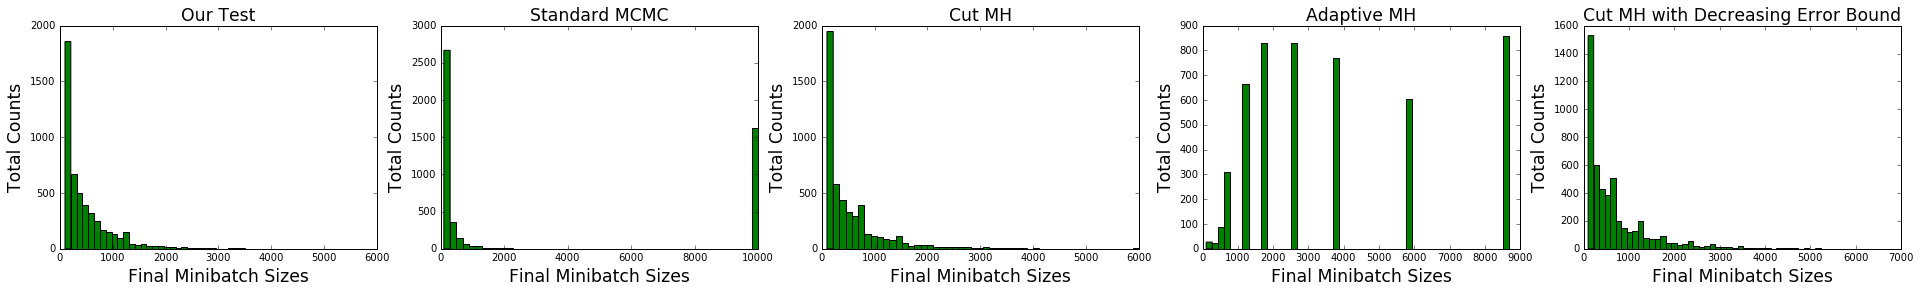

In [93]:
# plot minibatch size distribution
fig, axarr = plt.subplots(1,5, figsize=(33, 4))

axarr[0].set_title("Our Test", size="xx-large")
axarr[0].hist(size1, bins=50, facecolor ='green')
axarr[0].set_xlabel("Final Minibatch Sizes", size="xx-large")
axarr[0].set_ylabel("Total Counts", size="xx-large")

axarr[1].set_title("Standard MCMC", size="xx-large")
axarr[1].hist(size2, bins=50, facecolor ='green')
axarr[1].set_xlabel("Final Minibatch Sizes", size="xx-large")
axarr[1].set_ylabel("Total Counts", size="xx-large")

axarr[2].set_title("Cut MH", size="xx-large")
axarr[2].hist(size3, bins=50, facecolor ='green')
axarr[2].set_xlabel("Final Minibatch Sizes", size="xx-large")
axarr[2].set_ylabel("Total Counts", size="xx-large")

axarr[3].set_title("Adaptive MH", size="xx-large")
axarr[3].hist(size4, bins=50, facecolor ='green')
axarr[3].set_xlabel("Final Minibatch Sizes", size="xx-large")
axarr[3].set_ylabel("Total Counts", size="xx-large")

axarr[4].set_title("Cut MH with Decreasing Error Bound", size="xx-large")
axarr[4].hist(size5, bins=50, facecolor ='green')
axarr[4].set_xlabel("Final Minibatch Sizes", size="xx-large")
axarr[4].set_ylabel("Total Counts", size="xx-large")

print "Accelerate over old test is", np.sum(size2)/np.sum(size1)*1.0
print "Accelerate over cut mh budget test is", np.sum(size3)/np.sum(size1)*1.0
print "Accelerate over adaptive mh test is", np.sum(size4)/np.sum(size1)*1.0
print "Accelerate over cut mh budget test with decreasing error bound is", np.sum(size5)/np.sum(size1)*1.0

print 'time acceleration over old test is', time_list[1]/time_list[0]
print 'time acceleration over cut mh budget test is', time_list[2]/time_list[0]
print 'time acceleration over adaptive mh test is', time_list[3]/time_list[0]
print "time acceleration over cut mh budget test with decreasing error bound is",  time_list[4]/time_list[0]
plt.savefig('../figures/GaussianMixtureResult/minibatch_size_gaussian.eps', dpi=800)

In [105]:
np.mean(size5)

724.41998

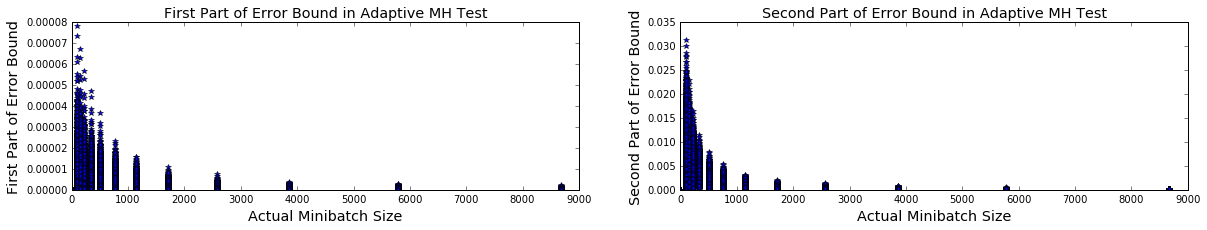

In [97]:
batch_size = bc1c2[:,0]
c1 = bc1c2[:,1]
c2 = bc1c2[:,2]
fig, axarr = plt.subplots(1,2, figsize=(20, 3))
axarr[0].set_title("First Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[0].plot(batch_size, c1,'*')
axarr[0].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[0].set_ylabel("First Part of Error Bound", size="x-large")

axarr[1].set_title("Second Part of Error Bound in Adaptive MH Test", size="x-large")
axarr[1].plot(batch_size, c2, '*')
axarr[1].set_xlabel("Actual Minibatch Size", size="x-large")
axarr[1].set_ylabel("Second Part of Error Bound", size="x-large")
plt.savefig('../figures/GaussianMixtureResult/first_second_part_gaussian.eps', dpi=800)

Logistic Regression Test Result

In [173]:
# plot test result with Logistic Regression Model
# test parameters : with nsamps = 2000, minibatchsize = 100, sigma_proposer = 0.05
# number of data points = 12007, temperature = 120
# Load data
f2 = h5py.File('logisticdata.mat');
samples1 = np.array(f2['newtestsamples']) 
samples2 = np.array(f2['oldtestsamples'])
samples3 = np.array(f2['cutmhsamples'])
samples4 = np.array(f2['adaptivemhsamples'])
size1 = np.array(f2['newtestsize'])
size2 = np.array(f2['oldtestsize'])
size3 = np.array(f2['cutmhsize'])
size4 = np.array(f2['adaptivemhsize'])
ll1 = np.array(f2['newtestll'])
ll2 = np.array(f2['oldtestll'])
ll3 = np.array(f2['cutmhll'])
ll4 = np.array(f2['adaptivemhll'])
bc1c2 = np.array(f2['adaptivemhbc1c2'])

Accelerate over old test is 11.6693364133
Accelerate over cut mh budget test is 0.92398152037
Accelerate over adaptive mh test is 23.6734586308


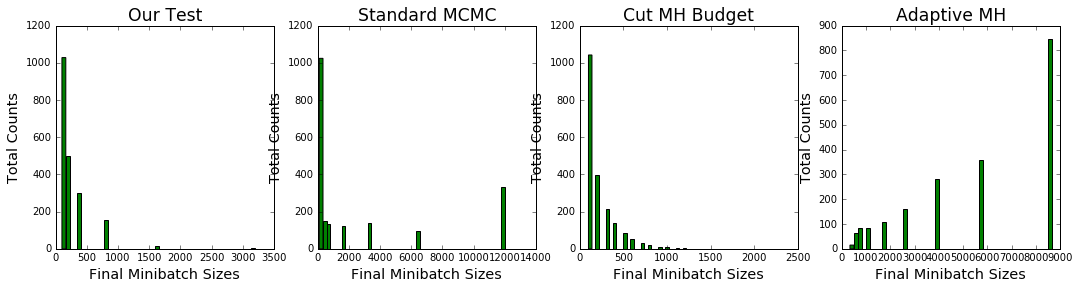

In [174]:
fig, axarr = plt.subplots(1,4, figsize=(18, 4))
axarr[0].set_title("Our Test", size="xx-large")
axarr[0].hist(size1, bins=50, facecolor ='green')
axarr[0].set_xlabel("Final Minibatch Sizes", size="x-large")
axarr[0].set_ylabel("Total Counts", size="x-large")

axarr[1].set_title("Standard MCMC", size="xx-large")
axarr[1].hist(size2, bins=50, facecolor ='green')
axarr[1].set_xlabel("Final Minibatch Sizes", size="x-large")
axarr[1].set_ylabel("Total Counts", size="x-large")

axarr[2].set_title("Cut MH Budget", size="xx-large")
axarr[2].hist(size3, bins=50, facecolor ='green')
axarr[2].set_xlabel("Final Minibatch Sizes", size="x-large")
axarr[2].set_ylabel("Total Counts", size="x-large")

axarr[3].set_title("Adaptive MH", size="xx-large")
axarr[3].hist(size4, bins=50, facecolor ='green')
axarr[3].set_xlabel("Final Minibatch Sizes", size="x-large")
axarr[3].set_ylabel("Total Counts", size="x-large")
print "Accelerate over old test is", np.sum(size2)/np.sum(size1)*1.0
print "Accelerate over cut mh budget test is", np.sum(size3)/np.sum(size1)*1.0
print "Accelerate over adaptive mh test is", np.sum(size4)/np.sum(size1)*1.0

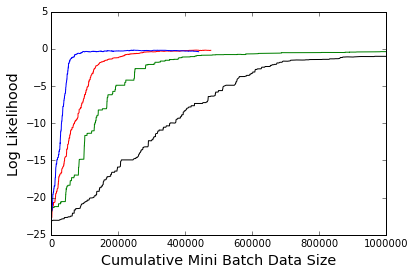

In [198]:
plt.plot(np.cumsum(size1).reshape([2000,1]), ll1.reshape([2000,1]), 'r')
plt.hold()
plt.plot(np.cumsum(size2).reshape([2000,1]), ll2.reshape([2000,1]), 'g')
plt.plot(np.cumsum(size3).reshape([2000,1]), ll3.reshape([2000,1]), 'b')
plt.plot(np.cumsum(size4).reshape([2000,1]), ll4.reshape([2000,1]), 'black')
axes = plt.gca()
axes.set_xlim([-10, 1000000])
axes.set_ylim([-25,5])
axes.set_xlabel("Cumulative Mini Batch Data Size", size = "x-large")
axes.set_ylabel("Log Likelihood", size = "x-large")
plt.show()